# Processing and Model Comparisons Notebook
In this notebook we compare differents methods to predict precence of CKD according to provided features.

## Imports

In [1]:
# Global Tools
import json
import os
from tqdm import tqdm

# Math / Data Manipulation
import numpy as np
from scipy.io import arff
import pandas as pd
import math

# Preprocessing / Modeling
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Viz
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


## Load Config

In [2]:
with open('../config.json', 'r') as f:
  config = json.load(f)
  
ROOT = os.path.dirname(os.path.abspath(os.path.curdir))


## Load Dataset


In [3]:
path_to_dataset_file = os.path.join(ROOT, config['dataset_dir'], config['dataset_file'])

data = arff.loadarff(path_to_dataset_file) # Work with advices found here : https://stackoverflow.com/questions/62653514/open-an-arff-file-with-scipy-io
df = pd.DataFrame(data[0])

print(f"Dataset Shape : {df.shape}")
df.head()


Dataset Shape : (400, 25)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,b'1.020',b'1',b'0',b'?',b'normal',b'notpresent',b'notpresent',121.0,...,44.0,7800.0,5.2,b'yes',b'yes',b'no',b'good',b'no',b'no',b'ckd'
1,7.0,50.0,b'1.020',b'4',b'0',b'?',b'normal',b'notpresent',b'notpresent',NaN,...,38.0,6000.0,NaN,b'no',b'no',b'no',b'good',b'no',b'no',b'ckd'
2,62.0,80.0,b'1.010',b'2',b'3',b'normal',b'normal',b'notpresent',b'notpresent',423.0,...,31.0,7500.0,NaN,b'no',b'yes',b'no',b'poor',b'no',b'yes',b'ckd'
3,48.0,70.0,b'1.005',b'4',b'0',b'normal',b'abnormal',b'present',b'notpresent',117.0,...,32.0,6700.0,3.9,b'yes',b'no',b'no',b'poor',b'yes',b'yes',b'ckd'
4,51.0,80.0,b'1.010',b'2',b'0',b'normal',b'normal',b'notpresent',b'notpresent',106.0,...,35.0,7300.0,4.6,b'no',b'no',b'no',b'good',b'no',b'no',b'ckd'




## Some Preprocess

In [4]:
# Rename column names with dataset info file to make it more understandable
path_to_info_file = os.path.join(ROOT, config['dataset_dir'], config['dataset_info_file'])
with open(path_to_info_file) as info_file:
    columns_and_desc = info_file.readlines()[31:56]
columns_names = map(lambda s : s.split('-')[1].strip().replace(' ', '_'), columns_and_desc)
df.columns = columns_names

# Decode byte to utf8
str_df = df.select_dtypes([object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df[col] = str_df[col]

# Drop empty values
df = df.dropna()

df.head()


,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,class
3,48.0,70.0,1.005,4,0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
5,60.0,90.0,1.015,3,0,?,?,notpresent,notpresent,74.0,...,39.0,7800.0,4.4,yes,yes,no,good,yes,no,ckd
9,53.0,90.0,1.020,2,0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd
11,63.0,70.0,1.010,3,0,abnormal,abnormal,present,notpresent,380.0,...,32.0,4500.0,3.8,yes,yes,no,poor,yes,no,ckd
12,68.0,70.0,1.015,3,1,?,normal,present,notpresent,208.0,...,28.0,12200.0,3.4,yes,yes,yes,poor,yes,no,ckd


## Features Encoding

In [5]:
target_col = config.get("target_col")
X = df[df.columns.difference([target_col])]
y = df[target_col]

In [6]:
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if X[col].dtype != 'object']
print(f"Number of categorical cols : {len(categorical_cols)}, Number of numerical cols : {len(numerical_cols)}")

Number of categorical cols : 13, Number of numerical cols : 11


In [7]:
old_features = X.columns
X = pd.get_dummies(X, columns=categorical_cols)
new_features = X.columns
print(f"Categorical Feature Encoding : {len(old_features)} Features --> {len(new_features)} Features")

Categorical Feature Encoding : 24 Features --> 60 Features


In [8]:
y = pd.Categorical(y)

## Split Train - Test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y.codes, test_size=config.get("test_size", 0.25), random_state=config.get("random_seed", 42))


## Models Comparison

In [10]:
models = [
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', xgb.XGBClassifier())
        ]

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']

In [11]:

cv_dfs = []

for name, model in tqdm(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=config.get("random_seed", 42))
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    cv_df = pd.DataFrame(cv_results)
    cv_df["model"] = name
    cv_dfs.append(cv_df)

df_results = pd.concat(cv_dfs, ignore_index=True)


100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


In [12]:
df_results.groupby("model").mean().sort_values(by=['test_f1_weighted'], ascending=False).style.background_gradient()

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc
model,,,,,,,
RF,0.042567,0.008095,1.000000,1.000000,1.000000,1.000000,1.000000
GNB,0.000928,0.002269,0.981250,0.984559,0.981250,0.981305,0.998413
XGB,0.090203,0.004325,0.956439,0.963887,0.956439,0.954826,1.000000
KNN,0.001194,0.061341,0.727083,0.786862,0.727083,0.703683,0.694896
SVM,0.001895,0.003095,0.678220,0.715891,0.678220,0.652807,0.738294


In [13]:
fig = go.Figure()

cols_metric = [col for col in df_results.columns if col.startswith('test')]
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)',
          'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']

for i, metric in enumerate(cols_metric):
    fig.add_trace(go.Box(
        y=df_results[metric],
        x=df_results["model"],
        name=metric,
        marker_color=colors[i]
    ))

fig.update_layout(
    yaxis_title='Scores',
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.show()

## Go Further with XGBoost

### Train and evaluate results

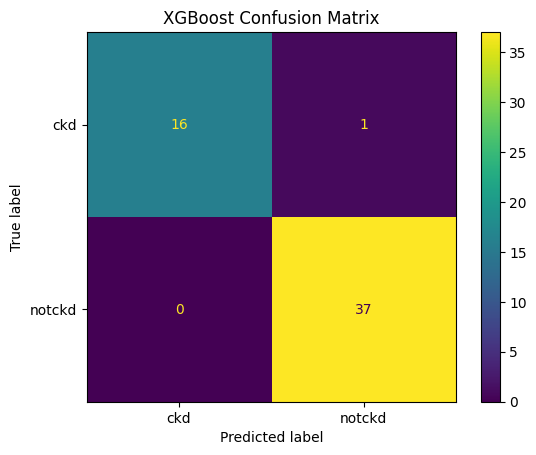

In [14]:
clf = xgb.XGBClassifier().fit(X_train, y_train)

cm = confusion_matrix(y_test, clf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y.categories)
disp.plot()
plt.title('XGBoost Confusion Matrix')
plt.show()

In [15]:
print(classification_report(y_test, clf.predict(X_test), target_names=y.categories))

              precision    recall  f1-score   support

         ckd       1.00      0.94      0.97        17
      notckd       0.97      1.00      0.99        37

    accuracy                           0.98        54
   macro avg       0.99      0.97      0.98        54
weighted avg       0.98      0.98      0.98        54



**98%** Accuracy is pretty good result on test set, the model seems to have "well understood" the dataset.

### Interpret Features Importance

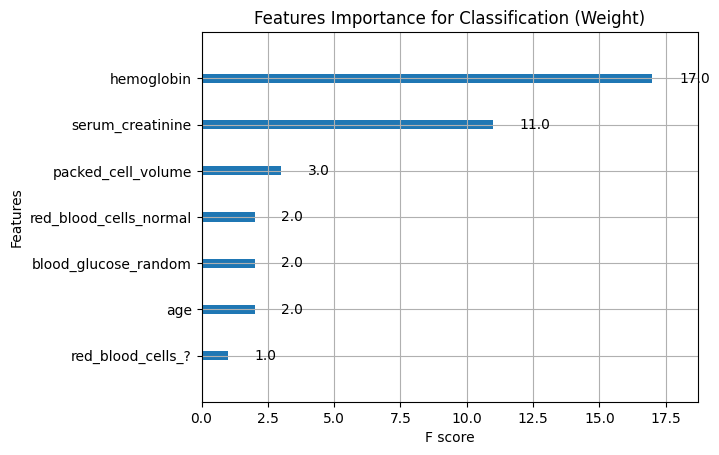

In [16]:
xgb.plot_importance(clf, importance_type='weight')
plt.title("Features Importance for Classification (Weight)")
plt.show()

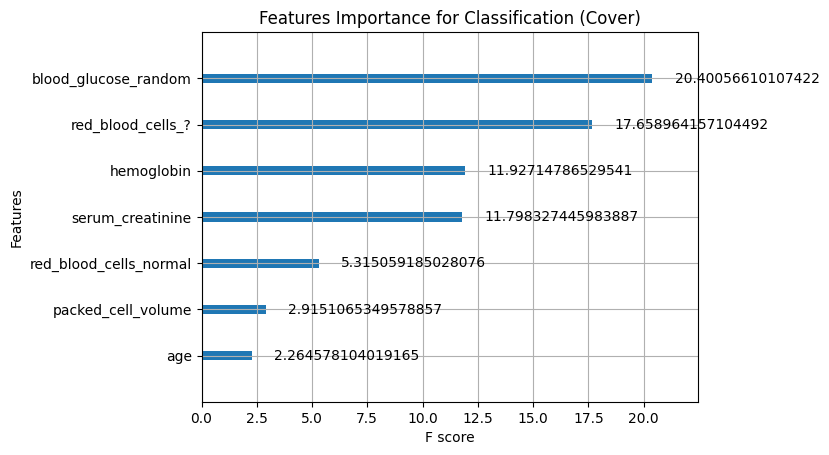

In [17]:
xgb.plot_importance(clf, importance_type="cover")
plt.title("Features Importance for Classification (Cover)")
plt.show()

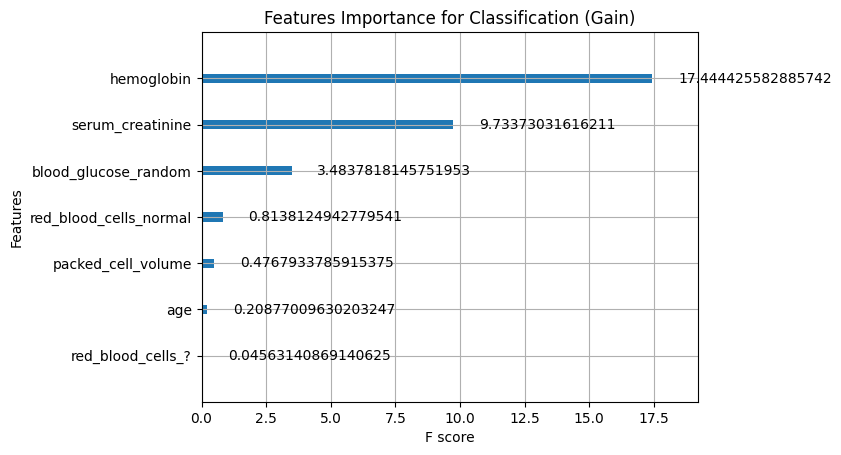

In [18]:
xgb.plot_importance(clf, importance_type="gain")
plt.title("Features Importance for Classification (Gain)")
plt.show()

Here ***hemoglobin***, ***serum creantine***, ***blood glucose random*** and ***presence of red blood cells*** seems to be important features for the model to make a decision.

For more informations about interpretability : https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27